                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     1132.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:58:22   Log-Likelihood:                -11669.
No. Observations:                9816   AIC:                         2.335e+04
Df Residuals:                    9809   BIC:                         2.340e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

<Figure size 800x600 with 0 Axes>

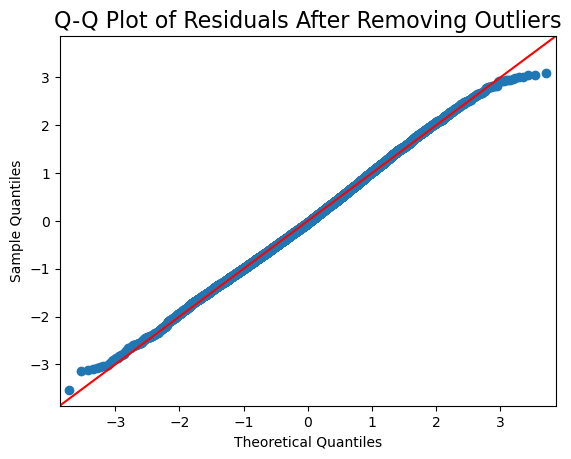

In [18]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast
from datetime import datetime
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Convert publication_date to datetime
df["publication_date"] = pd.to_datetime(df["publication_date"], errors="coerce")

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Apply log transformation to avg_author_citations_past_5_years
df["log_avg_author_citations_past_5_years"] = np.log1p(df["avg_author_citations_past_5_years"])  # log(1 + avg_author_citations_past_5_years)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_author_citations_past_5_years",  # Use log of avg_author_citations_past_5_years
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_institution_citations_past_5_years",
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the initial OLS regression model
model = sm.OLS(y, X).fit()

# Detect and remove outliers using standardized residuals
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal

# Define a threshold for outliers (e.g., |residual| > 3)
outlier_threshold = 3
non_outliers = np.abs(standardized_residuals) <= outlier_threshold

# Filter out outliers from the dataset
df_cleaned = df[non_outliers]

# Re-define X and y with the cleaned dataset
X_cleaned = df_cleaned[[
    "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_institution_citations_past_5_years",
]]
y_cleaned = df_cleaned["log_cited_by_count"]

# Add a constant term to the independent variables
X_cleaned = sm.add_constant(X_cleaned)

# Fit the OLS regression model on the cleaned data
model_cleaned = sm.OLS(y_cleaned, X_cleaned).fit()

# Print the summary of the regression model
print(model_cleaned.summary())

# Generate a Q-Q plot of the residuals
plt.figure(figsize=(8, 6))
sm.qqplot(model_cleaned.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals After Removing Outliers", fontsize=16)
plt.show()

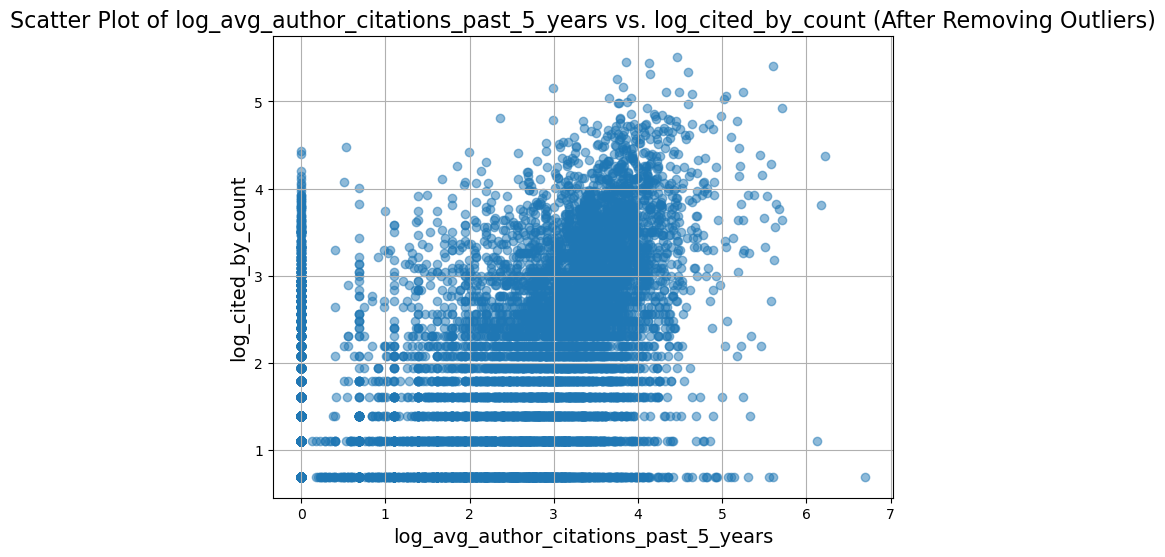

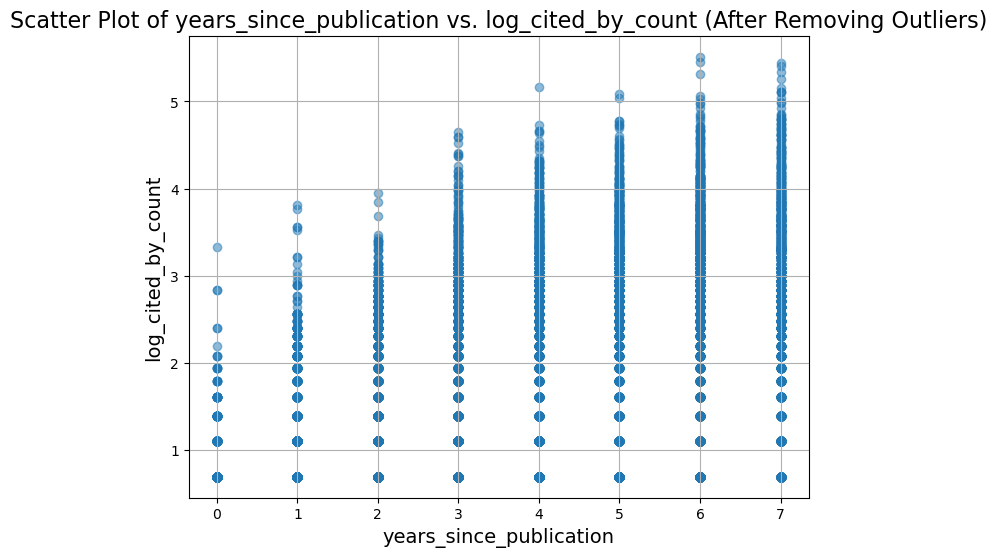

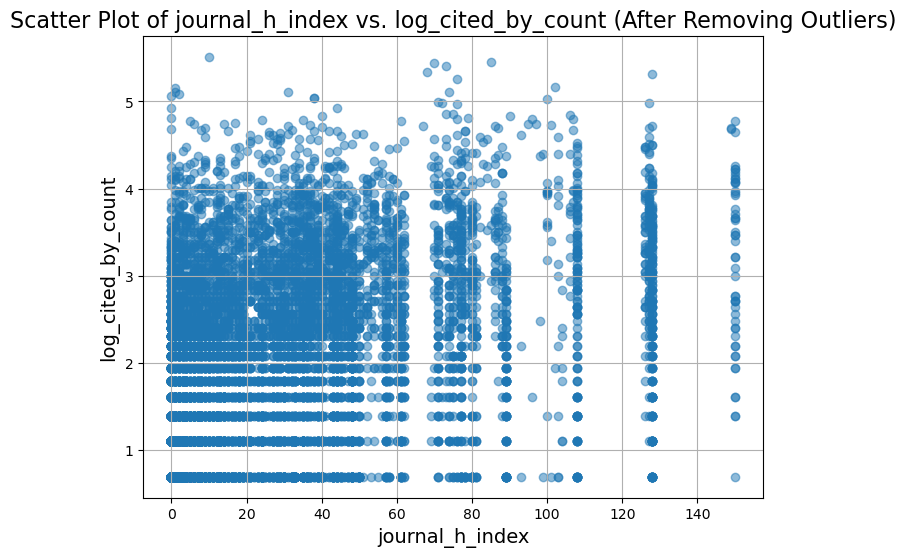

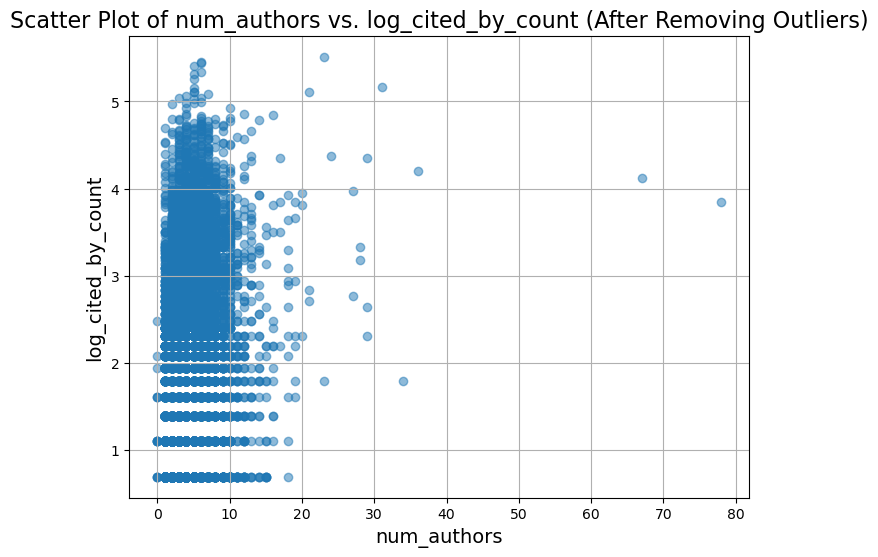

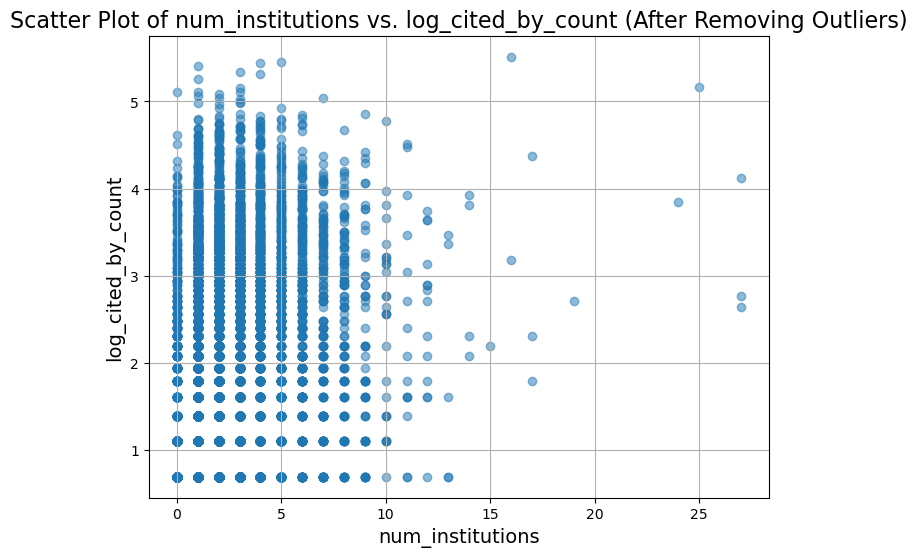

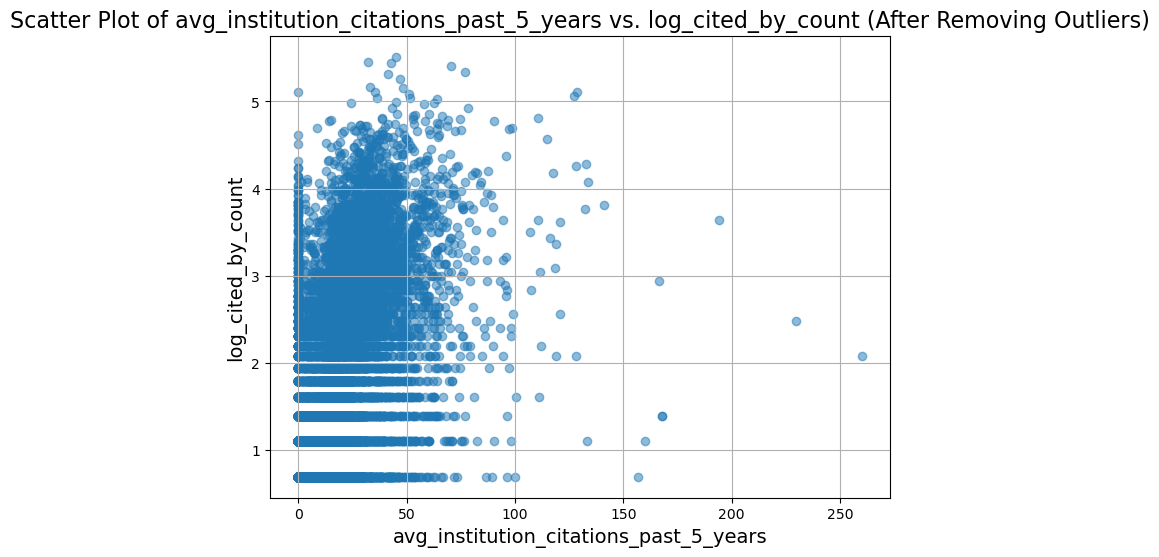

In [20]:
# Plot y_cleaned vs. each independent variable in X_cleaned
independent_vars = [
    "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_institution_citations_past_5_years"
]

for var in independent_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cleaned[var], y_cleaned, alpha=0.5)
    plt.title(f"Scatter Plot of {var} vs. log_cited_by_count (After Removing Outliers)", fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("log_cited_by_count", fontsize=14)
    plt.grid(True)
    plt.show()

In [21]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast
from datetime import datetime
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Convert publication_date to datetime
df["publication_date"] = pd.to_datetime(df["publication_date"], errors="coerce")

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Apply log transformation to avg_author_citations_past_5_years
df["log_avg_author_citations_past_5_years"] = np.log1p(df["avg_author_citations_past_5_years"])  # log(1 + avg_author_citations_past_5_years)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Detect and remove outliers using standardized residuals
X_initial = df[[
    "log_avg_author_citations_past_5_years", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_institution_citations_past_5_years",
]]
y_initial = df["log_cited_by_count"]
X_initial = sm.add_constant(X_initial)

# Fit the initial OLS regression model
model_initial = sm.OLS(y_initial, X_initial).fit()
influence = model_initial.get_influence()
standardized_residuals = influence.resid_studentized_internal

# Define a threshold for outliers (e.g., |residual| > 3)
outlier_threshold = 3
non_outliers = np.abs(standardized_residuals) <= outlier_threshold
df_cleaned = df[non_outliers]

# Run regression for each predicted_category
category_results = {}
categories = df_cleaned["predicted_category"].dropna().unique()

for category in categories:
    df_category = df_cleaned[df_cleaned["predicted_category"] == category]
    
    if len(df_category) < 10:  # Skip if there's not enough data
        continue
    
    X_cat = df_category[[
        "log_avg_author_citations_past_5_years", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions", 
        "avg_institution_citations_past_5_years",
    ]]
    y_cat = df_category["log_cited_by_count"]
    X_cat = sm.add_constant(X_cat)
    
    model_cat = sm.OLS(y_cat, X_cat).fit()
    category_results[category] = model_cat

# Print the summary for each category
for category, model in category_results.items():
    print(f"Category: {category}")
    print(model.summary())
    print("\n" + "="*80 + "\n")

Category: Physical Attributes
                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     498.9
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:17:13   Log-Likelihood:                -4336.1
No. Observations:                3774   AIC:                             8686.
Df Residuals:                    3767   BIC:                             8730.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

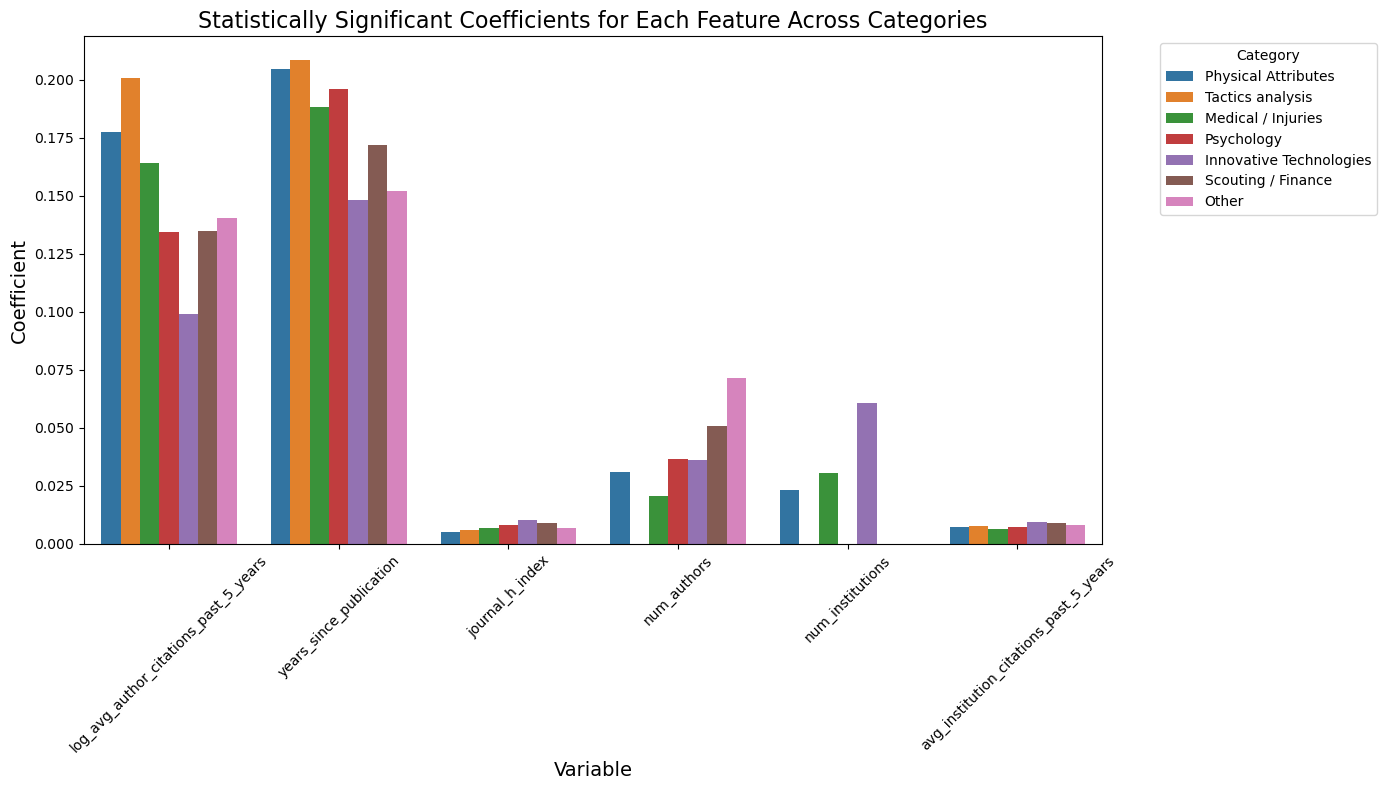

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance
for category, results in category_results.items():
    for variable in [
        "log_avg_author_citations_past_5_years",  # Update to match the modified variable
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions", 
        "avg_institution_citations_past_5_years"
    ]:
        coef = results.params.get(variable, 0)  # Extract coefficient
        p_value = results.pvalues.get(variable, 1)  # Extract p-value
        is_significant = p_value < 0.05  # Check if p-value indicates significance

        # Append only significant coefficients
        if is_significant:
            visualization_data.append({
                "Category": category,
                "Variable": variable,
                "Coefficient": coef
            })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Check if there is data to plot
if not coef_melted_with_significance.empty:
    # Plot only significant coefficients
    plt.figure(figsize=(14, 8))

    sns.barplot(
        data=coef_melted_with_significance,
        x="Variable",
        y="Coefficient",
        hue="Category",
        dodge=True,
        palette="tab10"  # Use distinct colors for categories
    )

    # Title and labels
    plt.title("Statistically Significant Coefficients for Each Feature Across Categories", fontsize=16)
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Coefficient", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()
else:
    print("No significant coefficients to plot.")